<a href="https://colab.research.google.com/github/KhyatiMahendru/StockPricePrediction/blob/master/AIProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# library to connect google sheets to colab for obtaining data
!pip install --upgrade -q gspread
import gspread

In [0]:
# user validation for google account
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
# opening required spreadsheet
worksheet = gc.open('googl1').sheet1

In [0]:
# creating complete dataframe 
rows = worksheet.get_all_values()
data = pd.DataFrame.from_records(rows)
data.columns = data.iloc[0]
data = data.drop(0).reset_index(drop = True)
data.head()

,Date,Close
0,19/08/2004 16:00:00,50.17
1,20/08/2004 16:00:00,54.16
2,23/08/2004 16:00:00,54.7
3,24/08/2004 16:00:00,52.44
4,25/08/2004 16:00:00,53


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3677 entries, 0 to 3676
Data columns (total 2 columns):
Date     3677 non-null object
Close    3677 non-null object
dtypes: object(2)
memory usage: 57.5+ KB


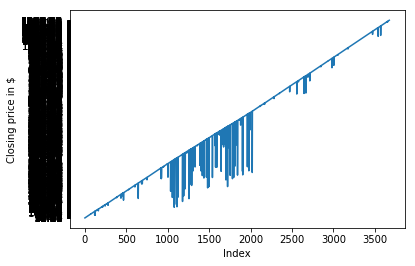

In [0]:
plt.plot(data['Close'])
plt.xlabel('Index')
plt.ylabel('Closing price in $')
plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# splitting into training and testing 
train, test = train_test_split(data, train_size = 0.80, test_size=0.20, shuffle=False)
print("Train and Test size", len(train), len(test))

# standardising the values
x = train.loc[:,"Close"].values
min_max_scaler = StandardScaler()
data = min_max_scaler.fit_transform(data.loc[:,"Close"].values.reshape(-1,1))
trainX = min_max_scaler.fit_transform(x.reshape(-1,1))
testX = min_max_scaler.transform(test.loc[:,"Close"].values.reshape(-1,1))

Train and Test size 2941 736


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

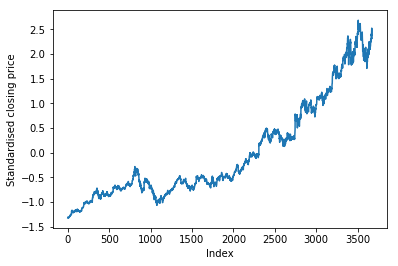

Variation in prices is observed better after standardisation


In [0]:
# visualising standardised dataset
plt.plot(data)
plt.xlabel('Index')
plt.ylabel('Standardised closing price')
plt.show()
print("Variation in prices is observed better after standardisation")

# Long Short-Term Memory

In [0]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = np.array(dataset[i:(i+look_back), 0])
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 7
trainX, trainY = create_dataset(trainX, look_back)
testX, testY = create_dataset(testX, look_back)

In [0]:
# reshaping trainX and testX into dimensions required by input layer
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
# building the model
model = Sequential()
model.add(LSTM(
    input_shape = (1, look_back),
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

# compiling model with Mean Square Error loss
model.compile(loss='mse', optimizer='rmsprop')

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 7), return_sequences=True, units=50)`
  """


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  


In [0]:
# training the model
model.fit(trainX, trainY, epochs= 800, batch_size=20, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/800
 - 3s - loss: 0.0918
Epoch 2/800
 - 1s - loss: 0.0152
Epoch 3/800
 - 1s - loss: 0.0142
Epoch 4/800
 - 1s - loss: 0.0134
Epoch 5/800
 - 1s - loss: 0.0130
Epoch 6/800
 - 1s - loss: 0.0119
Epoch 7/800
 - 1s - loss: 0.0122
Epoch 8/800
 - 1s - loss: 0.0116
Epoch 9/800
 - 1s - loss: 0.0118
Epoch 10/800
 - 1s - loss: 0.0107
Epoch 11/800
 - 1s - loss: 0.0108
Epoch 12/800
 - 1s - loss: 0.0104
Epoch 13/800
 - 1s - loss: 0.0097
Epoch 14/800
 - 1s - loss: 0.0099
Epoch 15/800
 - 1s - loss: 0.0096
Epoch 16/800
 - 1s - loss: 0.0101
Epoch 17/800
 - 1s - loss: 0.0098
Epoch 18/800
 - 1s - loss: 0.0095
Epoch 19/800
 - 1s - loss: 0.0098
Epoch 20/800
 - 1s - loss: 0.0095
Epoch 21/800
 - 1s - loss: 0.0092
Epoch 22/800
 - 1s - loss: 0.0092
Epoch 23/800
 - 1s - loss: 0.0095
Epoch 24/800
 - 1s - loss: 0.0090
Epoch 25/800
 - 1s - loss: 0.0091
Epoch 26/800
 - 1s - loss: 0.0097
Epoch 27/800
 - 1s - loss: 0.0098
Epoch 28/800
 - 1s - loss: 0.0092
Epoch 29/

In [0]:
# estimate model performance
import math
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.05 RMSE)
Test Score: 2.49 MSE (1.58 RMSE)


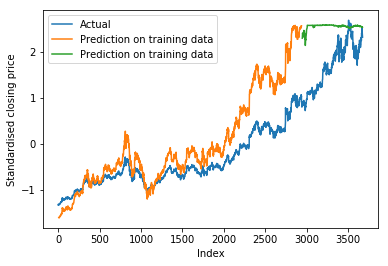

In [0]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

# plot baseline and predictions
plt.plot(data[:, 0], label = "Actual")
plt.plot(trainPredictPlot, label = "Prediction on training data")
plt.plot(testPredictPlot, label = "Prediction on training data")
plt.legend(loc = "best")
plt.xlabel('Index')
plt.ylabel('Standardised closing price')
plt.show()

# Gated Recurrent Unit

In [0]:
from keras.layers.recurrent import GRU
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

In [0]:
# building the model
model1 = Sequential()
model1.add(GRU(
    input_shape = (1, look_back),
    output_dim=50,
    return_sequences=True))
model1.add(Dropout(0.2))

model1.add(GRU(
    100,
    return_sequences=False))
model1.add(Dropout(0.2))

model1.add(Dense(
    output_dim=1))
model1.add(Activation('linear'))

# model is compiled with Mean Square Error Loss
model1.compile(loss="mse", optimizer="rmsprop")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(input_shape=(1, 7), return_sequences=True, units=50)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  


In [0]:
# fitting the model
model1.fit(trainX, trainY, epochs= 800, batch_size=20, verbose=2)

Epoch 1/800
 - 2s - loss: 0.0460
Epoch 2/800
 - 1s - loss: 0.0160
Epoch 3/800
 - 1s - loss: 0.0141
Epoch 4/800
 - 1s - loss: 0.0135
Epoch 5/800
 - 1s - loss: 0.0127
Epoch 6/800
 - 1s - loss: 0.0122
Epoch 7/800
 - 1s - loss: 0.0131
Epoch 8/800
 - 1s - loss: 0.0129
Epoch 9/800
 - 1s - loss: 0.0115
Epoch 10/800
 - 1s - loss: 0.0123
Epoch 11/800
 - 1s - loss: 0.0115
Epoch 12/800
 - 1s - loss: 0.0116
Epoch 13/800
 - 1s - loss: 0.0114
Epoch 14/800
 - 1s - loss: 0.0113
Epoch 15/800
 - 1s - loss: 0.0111
Epoch 16/800
 - 1s - loss: 0.0113
Epoch 17/800
 - 1s - loss: 0.0116
Epoch 18/800
 - 1s - loss: 0.0115
Epoch 19/800
 - 1s - loss: 0.0113
Epoch 20/800
 - 1s - loss: 0.0115
Epoch 21/800
 - 1s - loss: 0.0117
Epoch 22/800
 - 1s - loss: 0.0111
Epoch 23/800
 - 1s - loss: 0.0109
Epoch 24/800
 - 1s - loss: 0.0106
Epoch 25/800
 - 1s - loss: 0.0104
Epoch 26/800
 - 1s - loss: 0.0106
Epoch 27/800
 - 1s - loss: 0.0111
Epoch 28/800
 - 1s - loss: 0.0110
Epoch 29/800
 - 1s - loss: 0.0100
Epoch 30/800
 - 1s - lo

In [0]:
# Estimate model performance
import math
trainScore = model1.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model1.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

In [0]:
# generate predictions for training
trainPredict = model1.predict(trainX)
testPredict = model1.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

# plot baseline and predictions
plt.plot(data[:, 0], label = "Actual")
plt.plot(trainPredictPlot, label = "Prediction on training data")
plt.plot(testPredictPlot, label = "Prediction on training data")
plt.legend(loc = "best")
plt.xlabel('Index')
plt.ylabel('Standardised closing price')
plt.show()